**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Práctica 2.  Aprendizaje en entornos complejos**

## **1. Preparación del Entorno**

### 1.1 Introducción.  

Este notebook se enfoca en la implementación y análisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son: 

 - **FrozenLake (4x4)**

### 1.2. Instalación de Dependencias

Se instalan las librerías necesarias para trabajar con el entorno de simulación `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadrícula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desafíos.

In [6]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium 
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librerías

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random
import gc
import torch
from src_agents import *
from src_plotting import *

from src_agents.deepQLearning import *
import random
import numpy as np
import torch
import gymnasium as gym
from src_agents.sarsaSemiGradiente import FrozenLakeWrapper, train_sarsa#, GraphVisualizer
from src_plotting import *

### 1.4 Importación de los Entornos 

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un pequeño lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente útil para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensión de cómo el agente interactúa con el entorno.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempeño del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripción**: Graficará la proporción de recompensas obtenidas en cada episodio del entrenamiento. Este gráfico proporciona una visualización clara del progreso del agente, mostrando cómo mejora su desempeño a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripción**: Graficará la longitud de los episodios en el entrenamiento, y calculará y mostrará la tendencia de las longitudes utilizando una media móvil.

3. `plot_policy_blank(Q, env)`  
   - **Descripción**: Dibuja la política aprendida por el agente sobre un entorno vacío, representando las acciones óptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparación de Resultados de Entrenamiento")`  
   - **Descripción**: Compara la evolución de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparación de Longitudes de Episodios")`  
   - **Descripción**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgráficas separadas, con sombreado y media móvil.

Todas las funciones y clases relacionadas con la visualización de gráficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, será necesario importar las librerías correspondientes desde esa ruta.

## **2. Diseño del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementación de distintos agentes, organizados en módulos específicos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Además, se incluyen módulos auxiliares para definir políticas de exploración y visualizar resultados.

```plaintext
|-- 📂 src_agents                                    # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- 📄 __init__.py                               # Archivo que convierte el directorio en un paquete de Python
|   |-- 📄 agent.py                                  # Clase base para todos los agentes
|   |-- 📄 deepQLearning.py                          # Implementación del agente Deep Q-Learning (DQN)
|   |-- 📄 monteCarloOnPolicy.py                     # Implementación del agente Monte Carlo On-Policy
|   |-- 📄 monteCarloOffPolicy.py                    # Implementación del agente Monte Carlo Off-Policy
|   |-- 📄 qLearning.py                              # Implementación del agente Q-Learning
|   |-- 📄 sarsa.py                                  # Implementación del agente SARSA tabular
|   |-- 📄 sarsaSemiGradiente.py                     # Implementación del agente SARSA Semigradiente
|   |-- 📄 politicas.py                              # Definición de políticas de exploración como epsilon-greedy y softmax

|-- 📂 src_plotting                                  # Carpeta con herramientas de visualización de resultados
|   |-- 📄 __init__.py                               # Archivo que convierte el directorio en un paquete de Python
|   |-- 📄 plotting.py                               # Funciones de visualización de datos y gráficos


El diseño del agente consta de dos partes.  

- Las políticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Políticas del Agente

- **Epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida. 
   
- **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.  

- **Política greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentación - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadrícula donde cada celda puede ser suelo firme, un agujero o la meta. 

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versión estándar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la dirección elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se moverá exactamente en la dirección que elija sin desviaciones aleatorias. Esto hace que el problema sea más determinista y permite un aprendizaje más directo de las estrategias óptimas.

El objetivo del agente es llegar a la casilla de meta desde la posición inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una política óptima de manera más eficiente, ya que sus acciones tienen consecuencias predecibles.

### 3.5 Deep Q - Learning

# Deep Q-Learning (DQN)

Deep Q-Learning (DQN) es una extensión de Q-Learning que utiliza redes neuronales para aproximar la función de valor de estado-acción $ Q(s, a) $, permitiendo manejar espacios de estado continuos o de alta dimensión donde el enfoque tabular no es viable.


DQN utiliza una red neuronal que recibe el estado $ s $ como entrada y predice los valores $ Q(s, a) $ para cada acción posible. La actualización de $ Q(s, a) $ sigue la ecuación:

$y = r + \gamma \max_{a'} Q_{\text{target}}(s', a')$

donde $ Q_{\text{target}} $ es una copia de la red principal que se actualiza periódicamente para estabilizar el entrenamiento.


- **Replay Buffer**: Se almacenan transiciones $ (s, a, r, s') $ para romper la correlación entre experiencias y mejorar la estabilidad del aprendizaje.  
- **Target Network**: Se mantiene una red objetivo congelada que se actualiza cada cierto número de pasos para evitar oscilaciones en el entrenamiento.  
- **Exploración con $ \epsilon $-greedy**: Se usa $ \epsilon $-greedy con un decaimiento progresivo de $ \epsilon $ para favorecer la exploración al inicio y la explotación en etapas avanzadas.  
- **Función de pérdida**: Se minimiza el error cuadrático medio (MSE) entre la predicción de la red y la estimación corregida:

$L(\theta) = \mathbb{E} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]$



#### Mapa 4x4

Este fragmento de código establece una semilla fija para la generación de números aleatorios en varias bibliotecas, lo que garantiza la **reproducibilidad** en experimentos de Machine Learning o Aprendizaje por Refuerzo.

- `seed = 1995`: Se define una semilla fija con el valor `1995`.

- `random.seed(seed)`: Establece la semilla para la librería `random` de Python.

- `np.random.seed(seed)`: Fija la semilla para `NumPy`, garantizando que las funciones aleatorias de numpy generen los mismos valores en ejecuciones repetidas.

- `torch.manual_seed(seed)`: Configura la semilla en PyTorch para que las operaciones aleatorias en tensores de CPU sean reproducibles.

- `torch.cuda.manual_seed(seed)`: Si hay una GPU, fija la semilla en CUDA para asegurar la reproducibilidad en cálculos realizados en la GPU.


In [20]:
seed = 1995 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

El siguiente código crea un entorno de **FrozenLake** en Gymnasium

In [21]:
env = gym.make('FrozenLake-v1', is_slippery=False, map_name="4x4")

Realizamos el entrenamiento de un agente en el entorno **FrozenLake** utilizando el algoritmo **Deep Q-Learning (DQN)**:


In [22]:
episode_rewards_DQL, episode_lengths_DQL, training_errors_DQL, policy_net, target_net_DQL = train_dqn(env, num_episodes=25000, seed=seed)

Episode 50, Average Reward: 0.00, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.26, Epsilon: 0.47
Episode 200, Average Reward: 0.62, Epsilon: 0.37
Episode 250, Average Reward: 0.72, Epsilon: 0.29
Episode 300, Average Reward: 0.68, Epsilon: 0.22
Episode 350, Average Reward: 0.86, Epsilon: 0.17
Episode 400, Average Reward: 0.82, Epsilon: 0.13
Episode 450, Average Reward: 0.76, Epsilon: 0.10
Episode 500, Average Reward: 0.92, Epsilon: 0.08
Episode 550, Average Reward: 0.90, Epsilon: 0.06
Episode 600, Average Reward: 0.92, Epsilon: 0.05
Episode 650, Average Reward: 0.94, Epsilon: 0.04
Episode 700, Average Reward: 0.96, Epsilon: 0.03
Episode 750, Average Reward: 0.98, Epsilon: 0.02
Episode 800, Average Reward: 1.00, Epsilon: 0.02
Episode 850, Average Reward: 1.00, Epsilon: 0.01
Episode 900, Average Reward: 1.00, Epsilon: 0.01
Episode 950, Average Reward: 0.98, Epsilon: 0.01
Episode 1000, Average Reward: 1.00, Epsilon: 0.01
Episode 1050, Averag

**Conclusión**

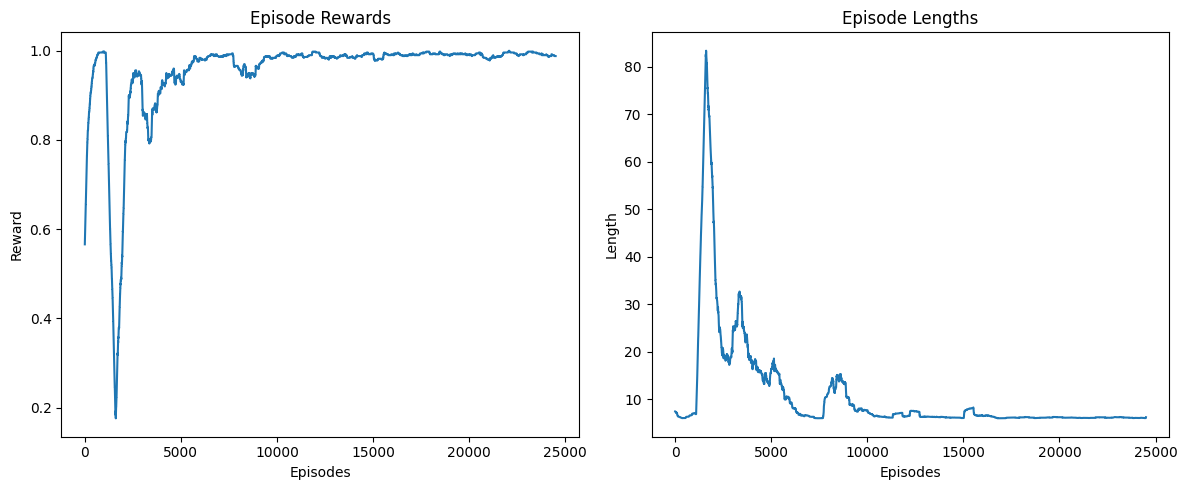

In [23]:
plot_all(episode_rewards_DQL, episode_lengths_DQL, training_errors_DQL, rolling_length=500)

Analizando las gráficas obtenidas durante el entrenamiento del agente con DQN en el entorno FrozenLake 4x4, podemos destacar los siguientes puntos:

- **Evolución de las recompensas** (Gráfica izquierda)
Al comienzo del entrenamiento, la recompensa media es baja y presenta fluctuaciones considerables, reflejando la fase de exploración inicial del agente.
A medida que avanzan los episodios (antes de llegar a los 2,000 aproximadamente), la recompensa aumenta de manera notable hasta estabilizarse cerca de valores próximos a 1. Esto indica que el agente ha aprendido a maximizar su probabilidad de alcanzar la meta.
En la etapa final, la recompensa se mantiene estable en valores altos, lo cual sugiere que el agente ha convergido a una política casi óptima, pese a la naturaleza estocástica del entorno.

- **Evolución de la longitud de los episodios** (Gráfica derecha)
Durante los primeros episodios, se observan picos de duración muy elevados (llegando a superar 80 pasos), señal de que el agente todavía no cuenta con una estrategia clara y está probando múltiples rutas sin éxito.
Con el progreso del entrenamiento, la longitud de los episodios desciende drásticamente, llegando a estabilizarse en valores bajos (cercanos a 5–10 pasos), lo que indica que el agente ha encontrado rutas eficientes para resolver el entorno.
Hacia la fase final, la longitud se mantiene relativamente constante, reforzando la idea de que el agente aplica una política sólida para llegar a la meta con el menor número de movimientos posibles.

**Conclusión general**
El entrenamiento con Deep Q-Learning en FrozenLake 4x4 demuestra ser exitoso. El agente pasa de episodios largos con recompensas bajas a episodios más cortos y recompensas cercanas al máximo. La estabilidad observada en ambos gráficos hacia el final del entrenamiento indica que el agente ha aprendido una política efectiva y robusta para navegar en un entorno estocástico, maximizando su recompensa y reduciendo los movimientos innecesarios.

### 3.6 Sarsa SemiGradiente

SARSA semigradiente es una extensión del algoritmo SARSA tradicional, diseñada para manejar entornos con espacios de estado continuos o de alta dimensión. En estos casos, la representación tabular de $ Q(s, a) $ se vuelve inviable, por lo que se emplean funciones de aproximación en lugar de almacenar valores discretos para cada par estado-acción.

El método SARSA semigradiente utiliza una función de aproximación de la forma:

$$
Q(s, a; \theta) \approx f(s, a; \theta)
$$

donde $ \theta $ representa un conjunto de parámetros ajustables que determinan la estimación de los valores $ Q(s, a) $. En lugar de actualizar una tabla de valores $ Q $, se actualizan los parámetros $ \theta $ mediante descenso de gradiente.

La actualización de los parámetros $ \theta $ sigue la regla de aprendizaje:

$$
\theta \leftarrow \theta + \alpha \delta \nabla_{\theta} Q(s, a; \theta)
$$

donde:

- $\alpha $ es la tasa de aprendizaje.
- $ \delta $ es el error temporal definido como:

$$
\delta = R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}; \theta) - Q(s, a; \theta)
$$

- $ \nabla_{\theta} Q(s, a; \theta) $ es el gradiente de la función de aproximación respecto a los parámetros $ \theta $.




#### Mapa 4x4

Comenzamos el código estableciendo la semilla para los generadores de números aleatorios en varias bibliotecas, asegurando que los experimentos sean reproducibles.
- **`seed = 1995`**: Se define el valor de la semilla como `1995`. 
- **`random.seed(seed)`**: Establece la semilla en el módulo `random` de Python.
-
- **`np.random.seed(seed)`**: Establece la semilla en el generador de números aleatorios de NumPy. 
-
- **`torch.manual_seed(seed)`**: Establece la semilla para el generador de números aleatorios de PyTorch en la CPU.
-
- **`if torch.cuda.is_available(): torch.cuda.manual_seed(seed)`**: Si se dispone de una GPU (es decir, si CUDA está disponible), esta línea establece la semilla para el generador de números aleatorios de PyTorch en la GPU. 

In [28]:
seed = 1995
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

En este fragmento de código, se está creando un entorno utilizando la clase `FrozenLakeWrapper`. con el parametro ``is_slippery = False``, para crear un entorno que no sea resbaladizo.


In [29]:
# Usamos FrozenLakeWrapper para crear el entorno
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="4x4")


Se entrena el modelo

In [26]:
# Entrenar usando SARSA semigradiente (en vez de DQN)
episode_rewards_SSG, episode_lengths_SSG, training_errors_SSG, agent = train_sarsa(env_wrapper, num_episodes=25000, seed=seed)

c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 50, Average Reward: 0.02, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.00, Epsilon: 0.47
Episode 200, Average Reward: 0.00, Epsilon: 0.37
Episode 250, Average Reward: 0.00, Epsilon: 0.29
Episode 300, Average Reward: 0.00, Epsilon: 0.22
Episode 350, Average Reward: 0.00, Epsilon: 0.17
Episode 400, Average Reward: 0.00, Epsilon: 0.13
Episode 450, Average Reward: 0.00, Epsilon: 0.10
Episode 500, Average Reward: 0.00, Epsilon: 0.10
Episode 550, Average Reward: 0.00, Epsilon: 0.10
Episode 600, Average Reward: 0.00, Epsilon: 0.10
Episode 650, Average Reward: 0.00, Epsilon: 0.10
Episode 700, Average Reward: 0.00, Epsilon: 0.10
Episode 750, Average Reward: 0.00, Epsilon: 0.10
Episode 800, Average Reward: 0.08, Epsilon: 0.10
Episode 850, Average Reward: 0.78, Epsilon: 0.10
Episode 900, Average Reward: 0.86, Epsilon: 0.10
Episode 950, Average Reward: 0.82, Epsilon: 0.10
Episode 1000, Average Reward: 0.82, Epsilon: 0.10
Episode 1050, Averag

**Conclusión**

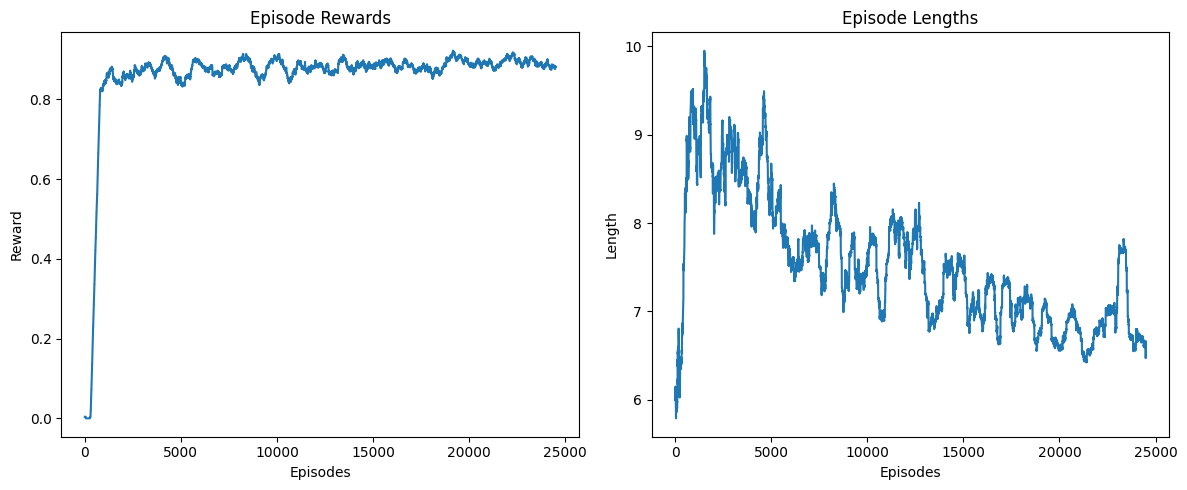

In [27]:
plot_all(episode_rewards_SSG, episode_lengths_SSG, training_errors_SSG, rolling_length=500)

Analizando las gráficas obtenidas durante el entrenamiento del agente con **Sarsa semigradiente** en el entorno **FrozenLake**, podemos destacar los siguientes puntos:


**Evolución de las recompensas** (Gráfica izquierda)
    - Al inicio del entrenamiento, las recompensas son bajas y muestran una alta variabilidad, lo cual indica que el agente se encuentra en fase de exploración y aún no ha desarrollado una estrategia clara.  
    - A medida que avanza el entrenamiento (alrededor de los primeros miles de episodios), la recompensa media asciende rápidamente, situándose cerca de valores de 0.8–0.9. Esto sugiere que el agente aprende a tomar decisiones que le permiten alcanzar la meta con mayor frecuencia.  
    - En la fase final, la recompensa se mantiene relativamente estable cerca de valores altos, lo que indica que el agente ha convergido a una política casi óptima.


**Evolución de la longitud de los episodios** (Gráfica derecha)
    - Durante los primeros episodios, la longitud de los mismos es relativamente alta y presenta fluctuaciones considerables, reflejando la exploración intensa del agente y la ausencia de una ruta clara hacia la meta.  
    - Conforme el agente adquiere experiencia, se observa una tendencia a la baja en la duración de los episodios. Esto indica que el agente aprende a llegar a la meta en menos pasos o, en caso de fallar, lo hace antes, reduciendo el tiempo total del episodio.  
    - En la etapa final del entrenamiento, la longitud de los episodios se estabiliza en valores más bajos, lo que demuestra que el agente ha aprendido la ruta más eficiente para resolver el entorno con el mínimo número de movimientos posibles.

**Conclusión general**
    El entrenamiento con **Sarsa semigradiente** en **FrozenLake** muestra resultados exitosos. El agente pasa de una fase de exploración errática, con bajas recompensas y episodios largos, a una estrategia consistente que maximiza la recompensa y minimiza la duración de los episodios. Aunque el entorno estocástico impide alcanzar un éxito absoluto, el rendimiento final del agente es alto y refleja la convergencia hacia una política efectiva y estable.

## **4. Conclusión**

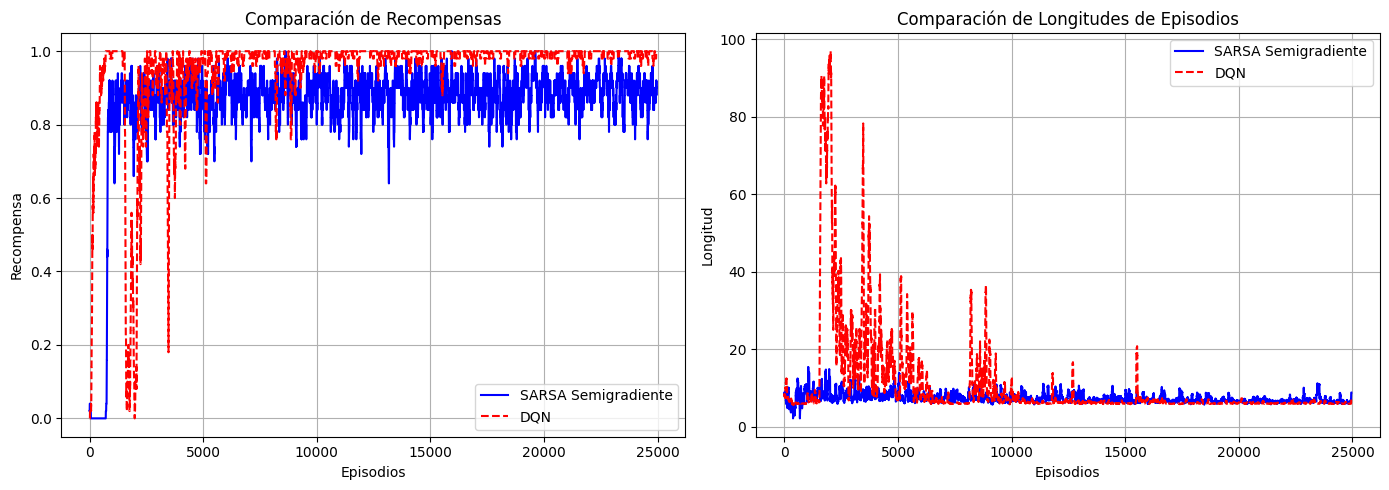

In [19]:
plot_comparative_results(episode_rewards_SSG, episode_lengths_SSG, 
                         episode_rewards_DQL, episode_lengths_DQL, 
                         label1="SARSA Semigradiente", label2="DQN",
                         rolling_length=50)

Analizando las gráficas comparativas de Sarsa Semigradiente (línea azul) y DQN (línea roja punteada) en el entorno FrozenLake 4x4, se pueden destacar los siguientes puntos:

**Comparación de Recompensas** (Gráfica izquierda)
- Fase inicial:
Tanto Sarsa Semigradiente como DQN comienzan con recompensas bajas e inestables, reflejando la etapa de exploración y la falta de una estrategia definida.  

- Progreso:
Sarsa Semigradiente muestra un ascenso paulatino hasta situarse cerca de valores de recompensa cercanos a 1, manteniéndose relativamente estable en ese rango.
DQN experimenta un incremento más rápido en las recompensas, pero presenta picos de inestabilidad en algunos tramos, donde la recompensa cae bruscamente antes de recuperarse.

Ambos métodos alcanzan recompensas promedio altas, lo que indica que aprenden políticas eficaces para superar el entorno. Sin embargo, DQN exhibe mayor variabilidad.

**Comparación de Longitudes de Episodios** (Gráfica derecha)

- Fase inicial:
Al inicio, la duración de los episodios para DQN es muy elevada, mientras que Sarsa Semigradiente se mantiene en rangos algo más moderados, aunque también inestables.  

- Progreso:
Con el paso de los episodios, ambas estrategias reducen significativamente la longitud media de los episodios. Esto sugiere que, al aprender la dinámica del entorno, el agente encuentra rutas más eficientes para llegar a la meta o, en caso de fallar, lo hace de forma más rápida.

Sarsa Semigradiente logra estabilizarse en valores relativamente bajos, mostrando una curva más homogénea.
DQN reduce también la duración de los episodios a valores bajos, pero sufre picos ocasionales que indican cierta inestabilidad en la política aprendida.

**Conclusión general**
Tanto Sarsa Semigradiente como DQN consiguen resolver de manera efectiva el entorno FrozenLake 4x4, alcanzando recompensas altas y reduciendo drásticamente la longitud de los episodios. No obstante, se aprecian diferencias en la estabilidad del aprendizaje:

Basandonos únicamente en la estabilidad y la consistencia de los resultados, Sarsa Semigradiente parece ser la mejor opción en este experimento con FrozenLake 4x4. Aunque DQN puede alcanzar recompensas similares o incluso aprender un poco más rápido en ciertos tramos, presenta más fluctuaciones tanto en la recompensa como en la longitud de los episodios, lo que indica una política menos estable.
